In [1]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,precision_score,f1_score
import numpy as np
import pandas as pd
from tensorflow.keras import layers
from tensorflow.keras.layers import Input,Dropout,Dense,Flatten
from tensorflow.keras.models import Model
from keras.utils.data_utils import get_file
import matplotlib
import matplotlib.pyplot as plt
from keras.callbacks import CSVLogger
from google.colab import drive
drive.mount('/content/drive/')
%matplotlib inline

Mounted at /content/drive/


In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
# Downloading training and test sets to local drive
try:
    data_path = get_file('kddcup.data_10_percent.gz', origin='http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz')
except:
    print('Error downloading')
    raise

df = pd.read_csv(data_path, header=None)
print("Read {} rows into dataframe.".format(len(df)))

2154496/2144903 [==============================] - 0s 0us/step
Read 494021 rows into dataframe.


In [4]:
columns = [
    'duration',
    'protocol_type',
    'service',
    'flag',
    'src_bytes',
    'dst_bytes',
    'land',
    'wrong_fragment',
    'urgent',
    'hot',
    'num_failed_logins',
    'logged_in',
    'num_compromised',
    'root_shell',
    'su_attempted',
    'num_root',
    'num_file_creations',
    'num_shells',
    'num_access_files',
    'num_outbound_cmds',
    'is_host_login',
    'is_guest_login',
    'count',
    'srv_count',
    'serror_rate',
    'srv_serror_rate',
    'rerror_rate',
    'srv_rerror_rate',
    'same_srv_rate',
    'diff_srv_rate',
    'srv_diff_host_rate',
    'dst_host_count',
    'dst_host_srv_count',
    'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate',
    'dst_host_srv_serror_rate',
    'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate',
    'label'
]
df.columns = columns

In [5]:
df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.00,0.00,0.00,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.00,0.00,0.00,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494016,0,tcp,http,SF,310,1881,0,0,0,0,...,255,1.0,0.0,0.01,0.05,0.00,0.01,0.0,0.0,normal.
494017,0,tcp,http,SF,282,2286,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,normal.
494018,0,tcp,http,SF,203,1200,0,0,0,0,...,255,1.0,0.0,0.06,0.05,0.06,0.01,0.0,0.0,normal.
494019,0,tcp,http,SF,291,1200,0,0,0,0,...,255,1.0,0.0,0.04,0.05,0.04,0.01,0.0,0.0,normal.


<Figure size 432x288 with 0 Axes>

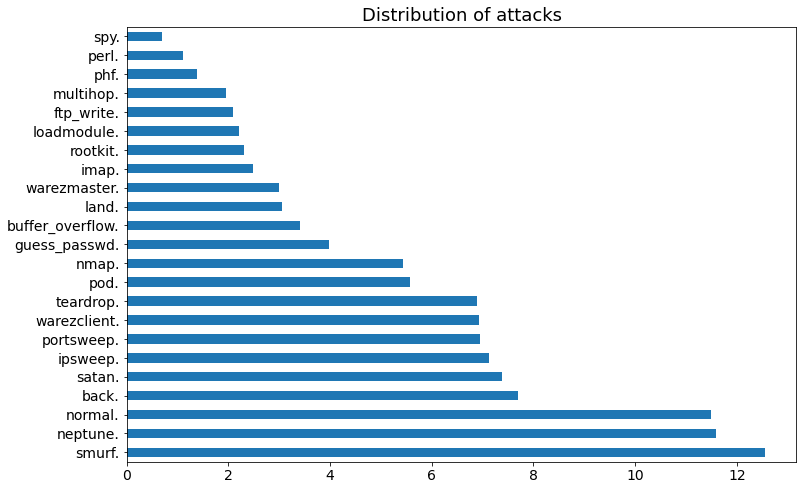

In [6]:
plt.clf()
plt.figure(figsize=(12,8))
params = {'axes.titlesize':'18',
          'xtick.labelsize':'14',
          'ytick.labelsize':'14'}
matplotlib.rcParams.update(params)
plt.title('Distribution of attacks')
#df.plot(kind='barh')
df['label'].value_counts().apply(np.log).plot(kind='barh')

plt.show()

In [7]:
def change_label(df):
  df.label.replace(['apache2.','back.','land.','neptune.','mailbomb.','pod.','processtable.','smurf.','teardrop.','udpstorm.','worm.'],'Dos',inplace=True)
  df.label.replace(['ftp_write.','guess_passwd.','httptunnel.','imap.','multihop.','named.','phf.','sendmail.',
       'snmpgetattack.','snmpguess.','spy.','warezclient.','warezmaster.','xlock.','xsnoop.'],'R2L',inplace=True)
  df.label.replace(['ipsweep.','mscan.','nmap.','portsweep.','saint.','satan.'],'Probe.',inplace=True)
  df.label.replace(['buffer_overflow.','loadmodule.','perl.','ps.','rootkit.','sqlattack.','xterm.'],'U2R',inplace=True)
  df.label.replace(['normal.'], 'Normal', inplace=True)
  df.label.replace(['Probe.'], 'Probe', inplace=True)

In [8]:
change_label(df)

<Figure size 432x288 with 0 Axes>

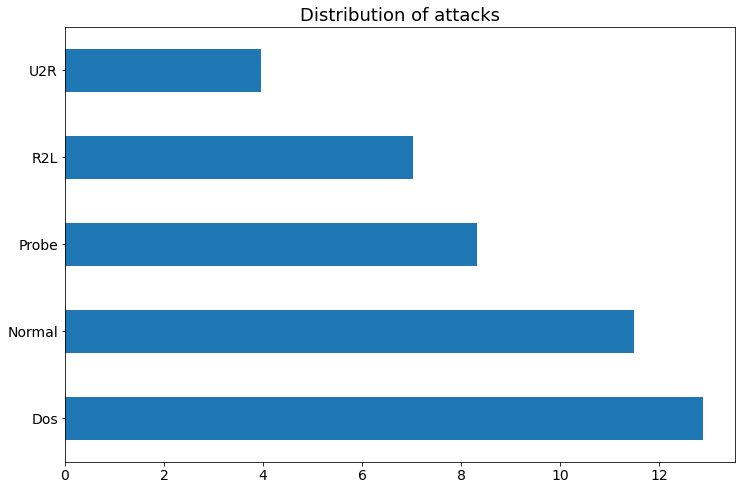

In [9]:
plt.clf()
plt.figure(figsize=(12,8))
params = {'axes.titlesize':'18',
          'xtick.labelsize':'14',
          'ytick.labelsize':'14'}
matplotlib.rcParams.update(params)
plt.title('Distribution of attacks')
#df.plot(kind='barh')
df['label'].value_counts().apply(np.log).plot(kind='barh')

plt.show()

In [10]:
df.label.value_counts()

Dos       391458
Normal     97278
Probe       4107
R2L         1126
U2R           52
Name: label, dtype: int64

In [11]:
numeric_col = df.select_dtypes(include='number').columns

In [12]:
std_scaler = MinMaxScaler()
def normalization(df,col):
  for i in col:
    arr = df[i]
    arr = np.array(arr)
    df[i] = std_scaler.fit_transform(arr.reshape(len(arr),1))
  return df

In [13]:
df = normalization(df.copy(),numeric_col)

In [14]:
# data after normalization
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0.0,tcp,http,SF,2.610418e-07,0.001057,0.0,0.0,0.0,0.0,...,0.035294,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,Normal
1,0.0,tcp,http,SF,3.446905e-07,0.000094,0.0,0.0,0.0,0.0,...,0.074510,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,Normal
2,0.0,tcp,http,SF,3.389216e-07,0.000259,0.0,0.0,0.0,0.0,...,0.113725,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,Normal
3,0.0,tcp,http,SF,3.158461e-07,0.000259,0.0,0.0,0.0,0.0,...,0.152941,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,Normal
4,0.0,tcp,http,SF,3.129617e-07,0.000394,0.0,0.0,0.0,0.0,...,0.192157,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,Normal


In [15]:
# one-hot encode
cat_col = ['protocol_type','service','flag']

In [16]:
categorical = df[cat_col]

In [17]:
categorical = pd.get_dummies(categorical,columns=cat_col)
df = pd.concat([df,categorical],axis=1)

In [18]:
df.drop('protocol_type', axis=1, inplace=True)
df.drop('service', axis=1, inplace=True)
df.drop('flag', axis=1, inplace=True)

df.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.0,2.610418e-07,0.001057,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,1,0
1,0.0,3.446905e-07,0.000094,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,1,0
2,0.0,3.389216e-07,0.000259,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,1,0
3,0.0,3.158461e-07,0.000259,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,1,0
4,0.0,3.129617e-07,0.000394,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,1,0


In [19]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical 

In [20]:
df.shape

(494021, 119)

In [21]:
data,labels=df,df.pop("label").values

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=23
)

In [22]:
train_data = train_data.values.reshape(train_data.shape[0], train_data.shape[1], -1)
test_data = test_data.values.reshape(test_data.shape[0], test_data.shape[1], -1)

In [23]:
train_data.shape, test_data.shape

((395216, 118, 1), (98805, 118, 1))

In [24]:
train_labels.shape, test_labels.shape

((395216,), (98805,))

In [25]:
input_shape = Input(shape = (train_data.shape[1], train_data.shape[2]))
input_shape

<KerasTensor: shape=(None, 118, 1) dtype=float32 (created by layer 'input_1')>

In [26]:
def encoder(input_shape):
    #encoder
    noise_layer = tf.keras.layers.GaussianNoise(.3, seed=0)(input_shape)

    conv1 = layers.Conv1D(256, 3, activation='relu', padding='same')(noise_layer)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Conv1D(256, 3, activation='relu', padding='same')(conv1)
    conv1 = layers.BatchNormalization()(conv1)

    conv2 = layers.Conv1D(128, 3, activation='relu', padding='same')(conv1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Conv1D(128, 3, activation='relu', padding='same')(conv2)
    conv2 = layers.BatchNormalization()(conv2)

    conv3 = layers.Conv1D(64, 3, activation='relu', padding='same')(conv2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Conv1D(64, 3, activation='relu', padding='same')(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Dropout(0.3, seed=0)(conv1)

    conv4 = layers.Conv1D(32, 3, activation='relu', padding='same')(conv3)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Conv1D(32, 3, activation='relu', padding='same')(conv4)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Dropout(0.3, seed=0)(conv1)
    return conv3

def decoder(conv4):    
    #decoder
    conv5 = layers.Conv1DTranspose(64, 3, activation='relu', padding='same')(conv4) 
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.Conv1DTranspose(64, 3, activation='relu', padding='same')(conv5)
    conv5 = layers.BatchNormalization()(conv5)
    conv6 = layers.Conv1DTranspose(128, 3, activation='relu', padding='same')(conv5) 
    conv6 = layers.BatchNormalization()(conv6)
    conv6 = layers.Conv1DTranspose(128, 3, activation='relu', padding='same')(conv6)
    conv6 = layers.BatchNormalization()(conv6)
    conv7 = layers.Conv1DTranspose(256, 3, activation='relu', padding='same')(conv6) 
    conv7 = layers.BatchNormalization()(conv7)
    conv7 = layers.Conv1DTranspose(256, 3, activation='relu', padding='same')(conv7)
    conv7 = layers.BatchNormalization()(conv7)
    decoded = layers.Conv1D(1, 3, activation='sigmoid', padding='same')(conv7)
    return decoded

autoencoder = Model(input_shape, decoder(encoder(input_shape)))

autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
    loss='mse',
    metrics=['accuracy']
)

In [27]:
history = autoencoder.fit(
    train_data,
    train_data,
    epochs=25,
    batch_size=128,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ]
)

Epoch 1/25
2471/2471 [==============================] - 252s 97ms/step - loss: 0.0075 - accuracy: 0.9585 - val_loss: 0.0030 - val_accuracy: 0.9667
Epoch 2/25
2471/2471 [==============================] - 236s 95ms/step - loss: 0.0060 - accuracy: 0.9601 - val_loss: 0.0010 - val_accuracy: 0.9670
Epoch 3/25
2471/2471 [==============================] - 235s 95ms/step - loss: 0.0060 - accuracy: 0.9601 - val_loss: 0.0012 - val_accuracy: 0.9670
Epoch 4/25
2471/2471 [==============================] - 234s 95ms/step - loss: 0.0059 - accuracy: 0.9602 - val_loss: 0.0014 - val_accuracy: 0.9670
Epoch 5/25
2471/2471 [==============================] - 235s 95ms/step - loss: 0.0058 - accuracy: 0.9603 - val_loss: 7.9282e-04 - val_accuracy: 0.9671
Epoch 6/25
2471/2471 [==============================] - 235s 95ms/step - loss: 0.0058 - accuracy: 0.9603 - val_loss: 9.2414e-04 - val_accuracy: 0.9671
Epoch 7/25
2471/2471 [==============================] - 236s 96ms/step - loss: 0.0058 - accuracy: 0.9604 - val

In [28]:
autoencoder.save('./drive/MyDrive/old_model/autoencoder_model.h5') 
autoencoder.save_weights('./drive/MyDrive/old_model/autoencoder.h5')

In [29]:
autoencoder = tf.keras.models.load_model('./drive/MyDrive/old_model/autoencoder_model.h5')

In [30]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 118, 1)]          0         
                                                                 
 gaussian_noise (GaussianNoi  (None, 118, 1)           0         
 se)                                                             
                                                                 
 conv1d (Conv1D)             (None, 118, 256)          1024      
                                                                 
 batch_normalization (BatchN  (None, 118, 256)         1024      
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 118, 256)          196864    
                                                                 
 batch_normalization_1 (Batc  (None, 118, 256)         1024  

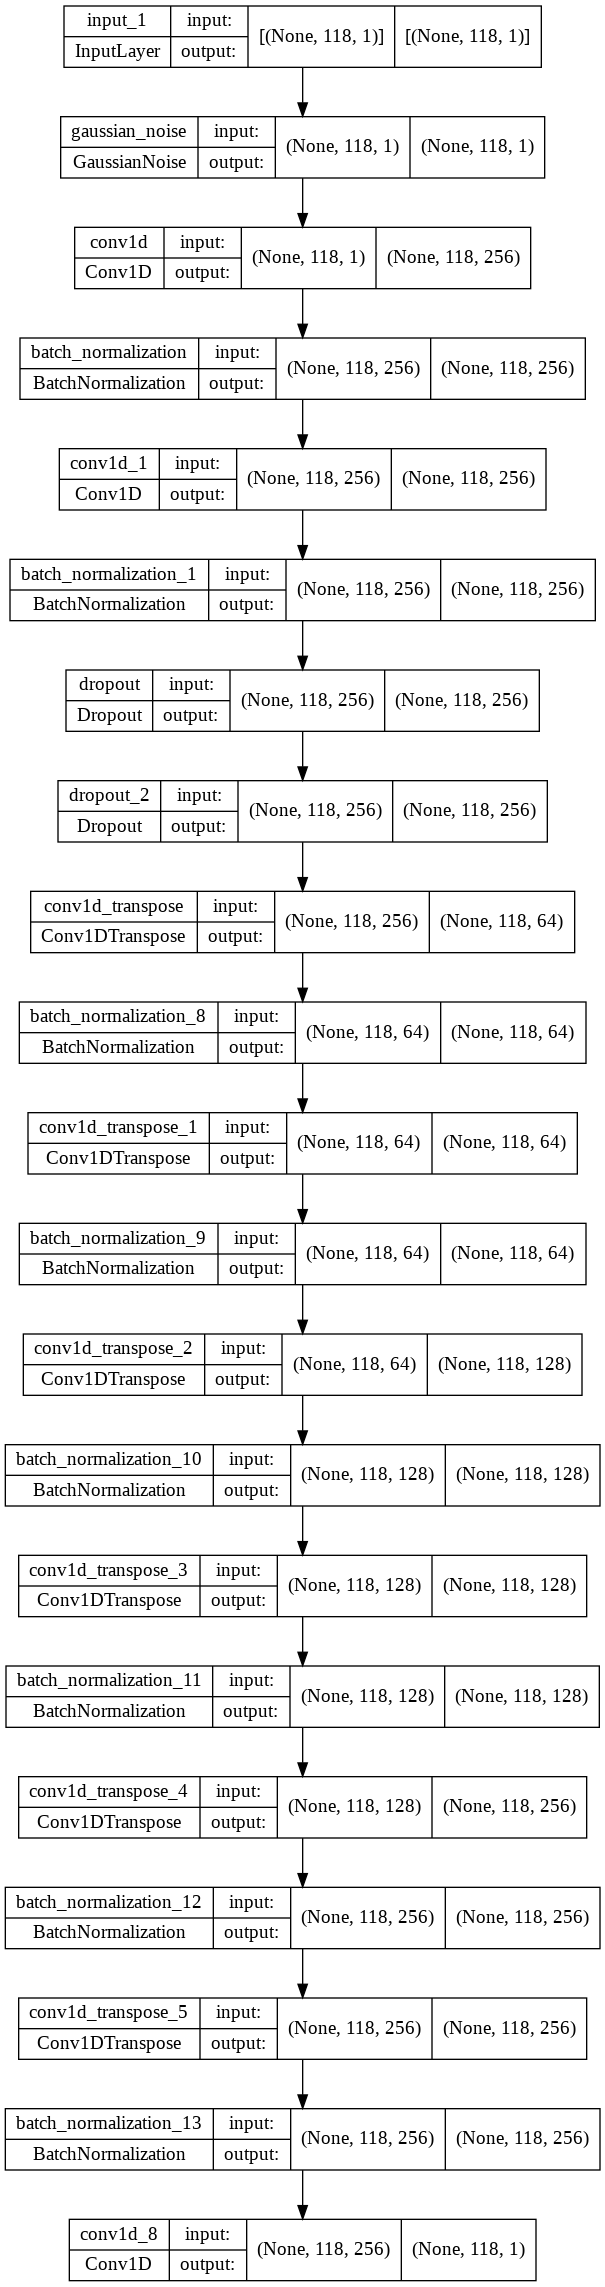

In [31]:
tf.keras.utils.plot_model(autoencoder, to_file='img.png', show_shapes=True)

In [32]:
train_Y_one_hot = pd.get_dummies(train_labels.copy())
test_Y_one_hot = pd.get_dummies(test_labels.copy())

In [33]:
print('Original label:', train_labels[0])
print('After conversion to one-hot:', train_Y_one_hot.loc[0])

Original label: Normal
After conversion to one-hot: Dos       0
Normal    1
Probe     0
R2L       0
U2R       0
Name: 0, dtype: uint8


# Classification

In [34]:
train_X,valid_X,train_label,valid_label = train_test_split(train_data,train_Y_one_hot,test_size=0.2,random_state=23)

In [35]:
train_X.shape,valid_X.shape,train_label.shape,valid_label.shape

((316172, 118, 1), (79044, 118, 1), (316172, 5), (79044, 5))

Load saved autoencoder model

In [36]:
def fc(enco):
    flat = Flatten()(enco)
    den = Dense(128, activation='relu')(flat)
    out = Dense(5, activation='softmax')(den)
    return out

In [37]:
encode = encoder(input_shape)
full_model = Model(input_shape,fc(encode))

In [ ]:
for l1,l2 in zip(full_model.layers[:18],autoencoder.layers[0:18]):
    l1.set_weights(l2.get_weights())

In [ ]:
autoencoder.get_weights()[0][1]

In [ ]:
full_model.get_weights()[0][1]

In [42]:
full_model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [ ]:
classify_train = full_model.fit(
    train_X, 
    train_label, 
    batch_size=64,
    epochs=25,
    verbose=1,
    validation_data=(valid_X, valid_label),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ])

Epoch 1/25
4941/4941 [==============================] - 119s 24ms/step - loss: 0.1236 - accuracy: 0.9872 - val_loss: 0.0353 - val_accuracy: 0.9911
Epoch 2/25
4941/4941 [==============================] - 111s 23ms/step - loss: 0.0425 - accuracy: 0.9895 - val_loss: 0.0336 - val_accuracy: 0.9915
Epoch 3/25
4941/4941 [==============================] - 115s 23ms/step - loss: 0.0382 - accuracy: 0.9905 - val_loss: 0.0291 - val_accuracy: 0.9923
Epoch 4/25
4808/4941 [============================>.] - ETA: 2s - loss: 0.0360 - accuracy: 0.9909

In [ ]:
full_model.summary()

In [ ]:
full_model.save('./drive/MyDrive/old_model/autoencoder_classification.h5') 
full_model.save_weights('./drive/MyDrive/old_model/autoencoder_classification_weights.h5')

Load saved classification model

In [ ]:
full_model = tf.keras.models.load_model('./drive/MyDrive/old_model/autoencoder_classification.h5')

In [ ]:
tf.keras.utils.plot_model(full_model, to_file='img.png', show_shapes=True)

In [ ]:
noise_layer = tf.keras.layers.Dropout(.3)
test_data_noised = noise_layer(test_data, training=True)

In [ ]:
test_eval = full_model.evaluate(test_data_noised, test_Y_one_hot, verbose=0)

In [ ]:
for metric_name, value in zip(full_model.metrics_names, test_eval):
  print(metric_name + ":", value)

In [ ]:
predicted_classes = full_model.predict(test_data_noised)

In [ ]:
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)

In [ ]:
predicted_classes.shape, test_labels.shape

In [ ]:
tl = pd.get_dummies(test_labels.copy())

In [ ]:
tl = tl.to_numpy()
tl = np.argmax(np.round(tl),axis=1)

In [ ]:
tl[0:5]

In [ ]:
predicted_classes[0:5]

In [ ]:
from sklearn.metrics import classification_report
target_names = [format(i) for i in ['Dos','Normal','Probe','R2L','U2R']]
print(classification_report(tl.astype(int), predicted_classes.astype(int), target_names=target_names))

In [ ]:
import seaborn as sns

In [ ]:
LABELS = ['DOS', 'Normal', 'Probe', 'R2L', 'U2R'] 
conf_matrix = confusion_matrix(tl.astype(int), predicted_classes.astype(int)) 
plt.figure(figsize =(12, 12)) 
sns.heatmap(conf_matrix, xticklabels = LABELS,  
            yticklabels = LABELS, annot = True, fmt ="d"); 
plt.title("Confusion matrix") 
plt.ylabel('True class')
plt.xlabel('Predicted class') 
plt.show()

In [ ]:
plt.plot(classify_train.history["loss"], label="Training Loss")
plt.plot(classify_train.history["val_loss"], label="Validation Loss")
plt.ylabel('Loss')
plt.legend()

In [ ]:
plt.plot(classify_train.history["fp"], label="Training")
plt.plot(classify_train.history["val_fp"], label="Validation")
plt.legend()